In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
from tqdm import tqdm

import inference.scheduler
from inference.distribution import Gaussian, GaussianMixture, Rosenbrock2D, InterpolatedDensity
from inference.sde import EulerMaruyamaSimulator, LangevinDynamics
import utils.vis2d.visualization

In [5]:
class LinearInterpolatedDensity(InterpolatedDensity):

    def __init__(self, density0, density1):
        super().__init__(density0, density1)
    
    def interpolate(self, log_density0: torch.Tensor, log_density1: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        Constructs interpolation between density0 and density1
        Args:
            - log_density0 (torch.Tensor): Log density of density0 evaluated at x
            - log_density1 (torch.Tensor): Log density of density1 evaluated at x
            - alpha (float): Interpolation parameter (0 <= alpha <= 1)
        """
        return log_density0 + alpha * (log_density1 - log_density0)

# Rate of Change of Fisher Divergence

Consider an interpolated density $p_t = F[p_0, p_1, t]$ which interpolates between an initial (easy) density $p_0$ and a final (hard) density $p_1$.

We can figure out how fast $p_t$ is moving away from $p_0$ by computing the rate of change of the Fisher divergence

$$
\frac{d}{dt} D_F(p_0 || p_t)  = 2~\mathbb E_{p_0} \left[s_t \cdot \frac{ds_t}{dt} + \nabla_x \cdot \frac{ds_t}{dt} \right]
$$
where $s_t = \nabla_x \log p_t(x)$ is the score function of $p_t$.

In linear interpolation (that is $F[p_0, p_1, t] = (1-t)p_0 + tp_1$), we have
$$
\frac{d}{dt} D_F(p_0 || p_t)  = 2~\mathbb E_{p_0} \Big[ -(1-t) s_0^2 + t s_1^2 + (1-2t) s_0 \cdot s_1 - \nabla_x \cdot s_0 + \nabla_x \cdot s_1\Big]
$$

In [ ]:
import torch

def divergence(func, x):
    """
    Compute the divergence of `func` evaluated at `x`.
    
    Args:
        func: function from (batch_size, 2) → (batch_size, 2)
        x: torch.Tensor of shape (batch_size, 2), requires_grad=True
    
    Returns:
        divergence: torch.Tensor of shape (batch_size,)
    """
    assert x.requires_grad, "Input x must have requires_grad=True"

    y = func(x)  # (batch_size, 2)
    div = torch.zeros(x.shape[0], device=x.device)

    for i in range(2):  # Loop over x and y dimensions
        grad_outputs = torch.zeros_like(y)
        grad_outputs[:, i] = 1.0  # Select i-th component
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]  # (batch_size, 2)
        div += grad[:, i]  # accumulate ∂f_i/∂x_i
    
    return div  # (batch_size,)


from inference.distribution import Sampleable, Density
def rateofchange(t, 
                 density0: Density,
                 density1: Density, 
                 num_samples: int = 1000) -> float:
    samples = density0.sample(num_samples=num_samples)
    score0 = density0.score(samples)
    score1 = density1.score(samples)

    # Terms
    term1 = -1 * (1-t) * torch.einsum('bi, bi -> b', score0, score0) # (num_samples,)
    term2 = t * torch.einsum('bi, bi -> b', score1, score1) #(num_samples,)
    term3 = (1 - 2*t) * torch.einsum('bi, bi -> b', score0, score1)  # (num_samples,)

    samples.requires_grad_(True)
    term4 = -1 * divergence(density0.score, samples)
    term5 = divergence(density1.score, samples)

    # Average terms
    term1 = torch.mean(term1)
    term2 = torch.mean(term2)
    term3 = torch.mean(term3)
    term4 = torch.mean(term4)
    term5 = torch.mean(term5)

    # Result
    return 2 * (term1 + term2 + term3 + term4 + term5)

## Unit Gaussian -> Gaussian Mixture

100%|██████████| 50/50 [00:02<00:00, 18.56it/s]


Text(0.5, 1.0, 'Rate of change of the Fisher divergence w.r.t Interpolated Density')

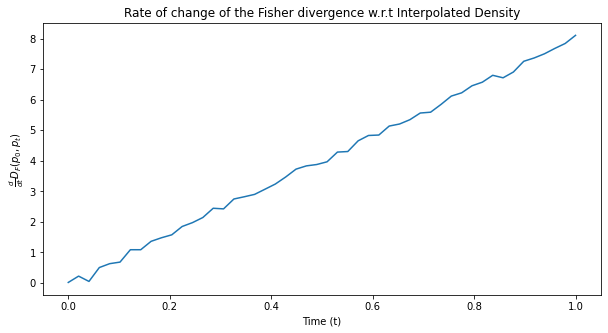

In [65]:
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = GaussianMixture.random_2D(nmodes=nmodes, 
                                     std=std, 
                                     scale=scale, 
                                     seed=seed)
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

times = torch.linspace(0, 1, 50)
rates = [rateofchange(t, density0, density1, num_samples=5000).detach().numpy() for t in tqdm(times)]


fig = plt.figure(figsize=(10, 5))

plt.plot(times, rates)

plt.xlabel('Time (t)')
plt.ylabel(r'$\frac{d}{dt}D_F(p_0, p_t)$')
plt.title('Rate of change of the Fisher divergence w.r.t Interpolated Density')

# Unit Gaussian to Rosenbrock

100%|██████████| 50/50 [00:01<00:00, 33.02it/s]


Text(0.5, 1.0, 'Rate of change of the Fisher divergence w.r.t Interpolated Density')

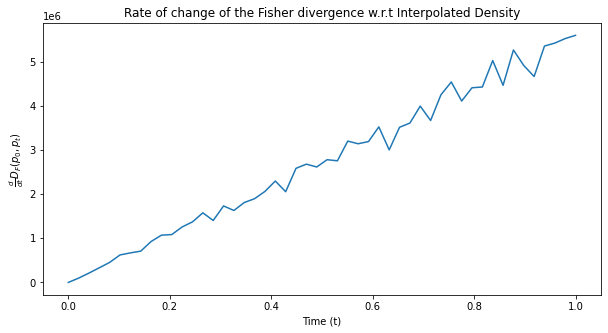

In [64]:
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = Rosenbrock2D()
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

times = torch.linspace(0, 1, 50)
rates = [rateofchange(t, density0, density1, num_samples=10000).detach().numpy() for t in tqdm(times)]


fig = plt.figure(figsize=(10, 5))

plt.plot(times, rates)

plt.xlabel('Time (t)')
plt.ylabel(r'$\frac{d}{dt}D_F(p_0, p_t)$')
plt.title('Rate of change of the Fisher divergence w.r.t Interpolated Density')

I originally thought this result was due to numerical error (look at the scale of the y-axis), but if you do the calculation in Mathematica, you get the same result... Seems like the Fisher divergence doesn't capture the change ideally...